In [1]:
'''
validation code.
using train datset
see ROC curve and histogram

'''
import numpy as np
import pandas as pd
from data_process import preprocess, to_vector
# from data_generator import PairSequence
from spectrum_utils.spectrum import MsmsSpectrum
import sklearn.preprocessing
import re
import argparse
import tensorflow as tf
import data_generator
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
from tensorflow.keras.layers import concatenate, Conv1D, Dense, Flatten, \
    Lambda, MaxPooling1D, Reshape
from tensorflow.keras.models import Model
from tensorflow_addons.optimizers import RectifiedAdam, AdamW
from tensorflow.keras import layers
import os
import pickle
from tensorflow.python.ops import math_ops

2023-12-12 13:20:07.909842: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 13:20:07.911053: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 13:20:07.936043: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 13:20:07.936547: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 13:20:08.402922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
def contrastive_loss(y_true: tf.Tensor, y_pred: tf.Tensor):
    """
    Contrastive loss function adapted from Hadsell et al. 2006.
    (http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)

    The contrastive loss is modified so that it takes a certainty that labels
    are correct into account. This helps the neural network to overcome
    incorrectly labeled instances.

    Parameters
    ----------
    y_true : tf.Tensor
        The true class labels.
    y_pred : tf.Tensor
        The predicted embedded Euclidean distances.

    Returns
    -------
    The contrastive loss between the true and predicted class labels.
    """
    ramp_square = K.square(K.minimum(y_pred, 1))
    # ramp_square = K.log(y_pred)
    # margin_square = K.log(1-y_pred)
    margin_square = K.square(K.maximum(1 - y_pred, 0))
    y_true = tf.cast(y_true, tf.float32)
    return K.mean(y_true * 0.99 * ramp_square +
                  (1 - y_true * 0.99) * margin_square)

In [2]:
# model = tf.keras.models.load_model('model3_12_5.h5',custom_objects={'contrastive_loss':contrastive_loss})
model = tf.keras.models.load_model('model3_12_8.h5')

In [3]:
model.summary()

Model: "base_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ms2_fragment (InputL  [(None, 2449)]               0         []                            
 ayer)                                                                                            
                                                                                                  
 input_seq (InputLayer)      [(None, 50, 21)]             0         []                            
                                                                                                  
 frag_embedder (Functional)  (None, 200)                  4487570   ['input_ms2_fragment[0][0]']  
                                                                                                  
 seq_embedder (Functional)   (None, 200)                  320904    ['input_seq[0][0]']  

In [4]:
train_pos = pd.read_csv("train_pos_12_11.tsv", delimiter= "\t")
train_neg = pd.read_csv("train_neg_12_11.tsv", delimiter= "\t")
test_pos = pd.read_csv("test_pos_12_11.tsv", delimiter= "\t")
test_neg = pd.read_csv("test_neg_12_11.tsv", delimiter= "\t")


In [5]:
f = open("/home/workplace/ms2/embedding/LIBRARY_AUGMENT-adfc8252-download_filtered_mgf_library-main.mgf")
mgf = f.readlines()
f.close()

In [6]:
train_generator = data_generator.gen_test(file_name_pos=train_pos, file_name_neg=train_neg, batch_size=256, mgf=mgf)
test_generator = data_generator.gen_test(file_name_pos=test_pos, file_name_neg=test_neg, batch_size=256, mgf=mgf)


In [7]:
result = []

for i,batch in enumerate(test_generator):
    # print(batch[0][0].shape)
    # print(batch[0][1].shape)
    # print(batch[1].shape)
    # print(len(batch[2]))
    dist = model.predict([batch[0][0], batch[0][1]])
    
    for dist_ele, label, seq, spec_seq in zip(dist, batch[1], batch[2][0], batch[2][1]):
        # dist = model.predict([vec,ohe])
        result.append((label, seq, spec_seq, dist_ele))
    
    if i > 2000:
        break

8/8 [==============================] - 0s 40ms/step


KeyboardInterrupt: 

In [8]:
result

[(1, 'NAALLVYDITR', 'NAALLVYDITR', array([-0.00499737], dtype=float32)),
 (1,
  'STIGVMVTASHNPEEDNGVK',
  'STIGVMVTASHNPEEDNGVK',
  array([-0.00499721], dtype=float32)),
 (1, 'LEAEDYLK', 'LEAEDYLK', array([-0.00499741], dtype=float32)),
 (1, 'VAAIEALNDGELQK', 'VAAIEALNDGELQK', array([-0.00499738], dtype=float32)),
 (1, 'SHLIYHQR', 'SHLIYHQR', array([-0.00499745], dtype=float32)),
 (1, 'EEEWTPTEK', 'EEEWTPTEK', array([-0.00499735], dtype=float32)),
 (1,
  'LPGAICSLTCGGADIGTAMAK',
  'LPGAICSLTCGGADIGTAMAK',
  array([-0.00499737], dtype=float32)),
 (1,
  'SVLCQENYLIQEGEEITCK',
  'SVLCQENYLIQEGEEITCK',
  array([-0.0049973], dtype=float32)),
 (1,
  'LNENPQLSEGWEIPK',
  'LNENPQLSEGWEIPK',
  array([-0.00499735], dtype=float32)),
 (1,
  'NQSIGLIQPFATNGK',
  'NQSIGLIQPFATNGK',
  array([-0.00499723], dtype=float32)),
 (1, 'TLTTLLEK', 'TLTTLLEK', array([-0.00499724], dtype=float32)),
 (1,
  'VGNCLIGGVSFTYCCTR',
  'VGNCLIGGVSFTYCCTR',
  array([-0.00499726], dtype=float32)),
 (1, 'KTEMVTISDASQR', '

In [9]:
len(result)

390158

In [10]:
with open("embedding_12_8.tsv", "w") as f:
    f.write("label,sequence,spectrum_sequence,distance\n")
    for ele in result:
        f.write(f"{ele[0]},{ele[1]},{ele[2]},{ele[3][0]}\n")

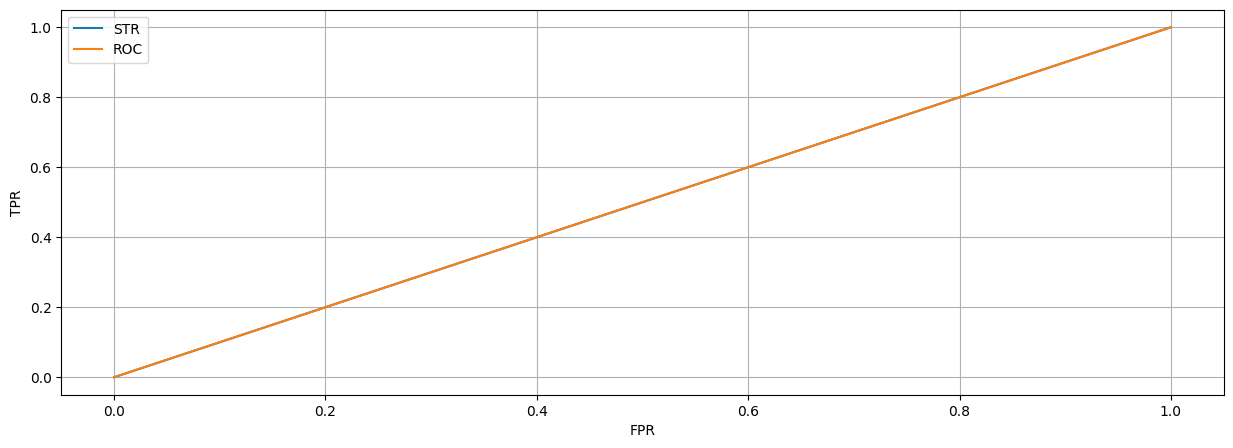

In [11]:
data = pd.read_csv("embedding_12_8.tsv")

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

predicted_label = []
for dist1 in data["distance"]:
    if dist1 < 0.95:
        predicted_label.append(1)
    else:
        predicted_label.append(0)
# predicted_label = data.loc[data["distance"]<0.9]

predicted_label = pd.Series(predicted_label)

fprs, tprs, thresholds = roc_curve(data["label"], predicted_label)

plt.figure(figsize=(15,5))
plt.plot([0,1],[0,1], label='STR')
plt.plot(fprs, tprs, label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


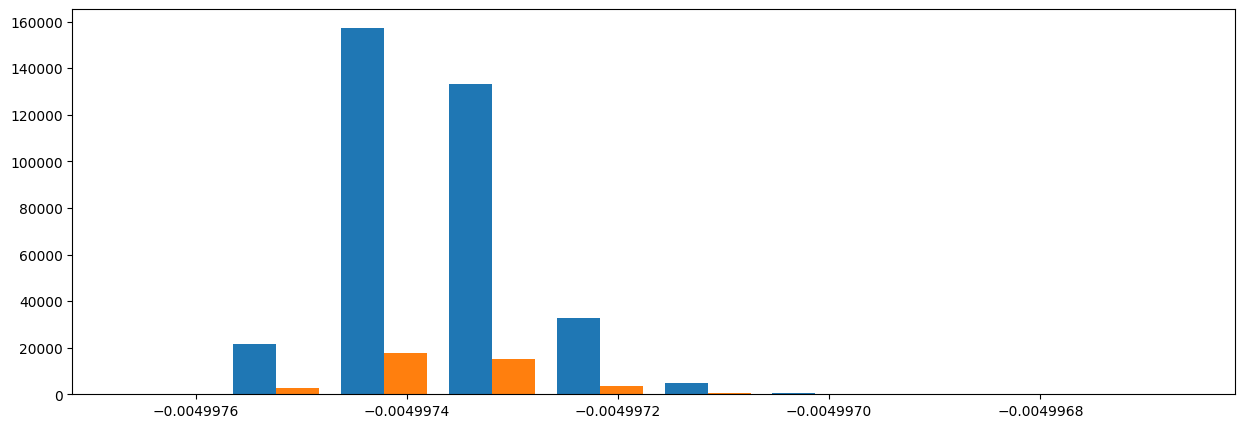

In [12]:
plt.figure(figsize=(15,5))

label0 = data.loc[data["label"] == 0]
label1 = data.loc[data["label"] == 1]
plt.hist([label0["distance"], label1["distance"]])
plt.show()